In [1]:
from collections import defaultdict, Counter
import math
import re
import pickle
import os

def load_tagged_sentences(path):
    """Load sentences using CH tag, but only sentence-ending punctuation"""
    sentence = []
    sentence_ending_punctuation = {'.', '!', '?', '...', '..'}  # Only sentence enders
    
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # Skip empty lines
                
            try:
                word, tag = re.split(r'\s+', line)
                sentence.append((word, tag))
                
                # Check if this is end of sentence (CH tag + sentence-ending punctuation)
                if tag == 'CH' and word in sentence_ending_punctuation:
                    if sentence:
                        yield sentence
                        sentence = []
                        
            except ValueError:
                # Handle malformed lines
                continue
    
    # Yield final sentence if exists
    if sentence:
        yield sentence


# Step 2: Segment into sentences using 'CH' (punctuation) tag
def segment_sentences(flat_tagged_data):
    sentences = []
    sentence = []
    for word, tag in flat_tagged_data:
        sentence.append((word, tag))
        if tag == 'CH':
            sentences.append(sentence)
            sentence = []
    if sentence:
        sentences.append(sentence)
    return sentences

# Step 3: Train HMM model
def train_trigram_hmm(sentences_path, min_count=2):
    # Build vocabulary first
    word_counts = Counter()
    for sentence in load_tagged_sentences(sentences_path):
        for word, _ in sentence:
            word_counts[word] += 1
    
    vocab = {word for word, count in word_counts.items() if count >= min_count}
    vocab.update(['<UNK>', '<s>', '</s>'])
    
    # Train model
    emission_counts = defaultdict(Counter)
    trigram_counts = Counter()
    bigram_counts = Counter()
    unigram_counts = Counter()
    tagset = set(['<s>', '</s>'])

    for sentence in load_tagged_sentences(sentences_path):
        # Replace rare words with <UNK>
        processed_sentence = []
        for word, tag in sentence:
            word = word if word in vocab else '<UNK>'
            processed_sentence.append((word, tag))
            tagset.add(tag)

        words = ['<s>', '<s>'] + [w for w, t in processed_sentence] + ['</s>']
        tags = ['<s>', '<s>'] + [t for w, t in processed_sentence] + ['</s>']

        for word, tag in processed_sentence:
            emission_counts[tag][word] += 1

        for i in range(len(tags)):
            unigram_counts[tags[i]] += 1
        for i in range(len(tags)-1):
            bigram_counts[(tags[i], tags[i+1])] += 1
        for i in range(len(tags)-2):
            trigram_counts[(tags[i], tags[i+1], tags[i+2])] += 1

    return emission_counts, trigram_counts, bigram_counts, unigram_counts, tagset, vocab

# Add probability cache class
class ProbabilityCache:
    def __init__(self, emission_counts, trigram_counts, bigram_counts, tagset, vocab):
        self.emission_counts = emission_counts
        self.trigram_counts = trigram_counts
        self.bigram_counts = bigram_counts
        self.tagset = tagset
        self.vocab = vocab
        self.tagset_size = len(tagset)
        self.vocab_size = len(vocab)
        
        # Pre-compute tag totals
        self.tag_totals = {}
        for tag in emission_counts:
            self.tag_totals[tag] = sum(emission_counts[tag].values())
    
    def trigram_prob(self, t1, t2, t3):
        numerator = self.trigram_counts[(t1, t2, t3)] + 1
        denominator = self.bigram_counts[(t1, t2)] + self.tagset_size
        return math.log(numerator / denominator)
    
    def emission_prob(self, tag, word):
        numerator = self.emission_counts[tag][word] + 1
        denominator = self.tag_totals.get(tag, 0) + self.vocab_size
        return math.log(numerator / denominator)

# Add testing function
def test_model(test_path, prob_cache):
    correct = 0
    total = 0
    
    for sentence in load_tagged_sentences(test_path):
        words = [w for w, _ in sentence]
        true_tags = [t for _, t in sentence]
        
        # Predict tags
        predicted_tags = viterbi_decode(words, prob_cache)
        
        for true_tag, pred_tag in zip(true_tags, predicted_tags):
            if true_tag == pred_tag:
                correct += 1
            total += 1
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total

def viterbi_decode(sentence, prob_cache):
    n = len(sentence)
    tagset = prob_cache.tagset
    vocab = prob_cache.vocab
    
    V = [{} for _ in range(n + 1)]
    backpointer = [{} for _ in range(n + 1)]
    
    V[0][('<s>', '<s>')] = 0.0
    
    for i in range(n):
        word = sentence[i] if sentence[i] in vocab else '<UNK>'
        
        for (t1, t2) in V[i]:
            for t3 in tagset:
                if t3 in ['<s>', '</s>']:
                    continue
                    
                trans_prob = prob_cache.trigram_prob(t1, t2, t3)
                emis_prob = prob_cache.emission_prob(t3, word)
                score = V[i][(t1, t2)] + trans_prob + emis_prob
                
                key = (t2, t3)
                if key not in V[i+1] or score > V[i+1][key]:
                    V[i+1][key] = score
                    backpointer[i+1][key] = (t1, t2)
    
    if not V[n]:
        return ['<UNK>'] * n
    
    best_final = max(V[n], key=V[n].get)
    
    tags = []
    current = best_final
    for i in range(n, 0, -1):
        tags.append(current[1])
        if i > 1 and current in backpointer[i]:
            current = backpointer[i][current]
    
    return list(reversed(tags))

def save_hmm_model(prob_cache, model_path, train_results=None):
    """Save the trained HMM model to disk with better error handling"""
    try:
        model_data = {
            'emission_counts': dict(prob_cache.emission_counts),  # Convert defaultdict to dict
            'trigram_counts': dict(prob_cache.trigram_counts),
            'bigram_counts': dict(prob_cache.bigram_counts),
            'tagset': prob_cache.tagset,
            'vocab': prob_cache.vocab,
            'tag_totals': prob_cache.tag_totals,
            'tagset_size': prob_cache.tagset_size,
            'vocab_size': prob_cache.vocab_size,
            'train_results': train_results,
            'model_type': 'HMM',
            'version': '1.0'  # Add version for compatibility checking
        }
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        
        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"HMM model saved to {model_path}")
        print(f"Tagset size: {len(prob_cache.tagset)}")
        print(f"Vocab size: {len(prob_cache.vocab)}")
        
    except Exception as e:
        print(f"Error saving model: {str(e)}")
        raise e

def load_hmm_model(model_path):
    """Load a trained HMM model from disk with validation"""
    try:
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
        
        # Validate required fields
        required_fields = ['emission_counts', 'trigram_counts', 'bigram_counts', 
                          'tagset', 'vocab', 'tagset_size', 'vocab_size']
        
        for field in required_fields:
            if field not in model_data:
                raise ValueError(f"Missing required field: {field}")
        
        # Convert back to defaultdict if needed
        emission_counts = defaultdict(Counter)
        for tag, word_counts in model_data['emission_counts'].items():
            emission_counts[tag] = Counter(word_counts)
        
        trigram_counts = Counter(model_data['trigram_counts'])
        bigram_counts = Counter(model_data['bigram_counts'])
        
        # Recreate ProbabilityCache with loaded data
        prob_cache = ProbabilityCache(
            emission_counts,
            trigram_counts,
            bigram_counts,
            model_data['tagset'],
            model_data['vocab']
        )
        
        print(f"HMM model loaded from {model_path}")
        print(f"Tagset size: {len(prob_cache.tagset)}")
        print(f"Vocab size: {len(prob_cache.vocab)}")
        
        return prob_cache, model_data.get('train_results')
        
    except FileNotFoundError:
        print(f"Model file not found: {model_path}")
        raise
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise e

In [2]:
# Add these imports at the top
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

# Replace the evaluate_with_sklearn function to work with your code
def evaluate_with_sklearn(test_path, prob_cache, verbose=False):
    """Evaluate HMM model using sklearn metrics"""
    y_true = []
    y_pred = []
    
    for sentence in load_tagged_sentences(test_path):
        words = [word for word, _ in sentence]
        true_tags = [tag for _, tag in sentence]
        predicted_tags = viterbi_decode(words, prob_cache)
        
        # Flatten predictions and true tags
        y_true.extend(true_tags)
        y_pred.extend(predicted_tags)
    
    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    
    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Convert to DataFrame for better visualization
    df_report = pd.DataFrame(report).transpose()
    
    # Print results
    print(f"\n=== Sklearn Evaluation Results for HMM ===")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print("\nDetailed Classification Report:")
    print(df_report.round(4))
    
    # Create a summary table for main metrics
    main_tags = [tag for tag in df_report.index if tag not in ['accuracy', 'macro avg', 'weighted avg']]
    summary_data = []
    
    for tag in main_tags:
        summary_data.append({
            'Tag': tag,
            'Precision': df_report.loc[tag, 'precision'],
            'Recall': df_report.loc[tag, 'recall'],
            'F1-Score': df_report.loc[tag, 'f1-score'],
            'Support': int(df_report.loc[tag, 'support'])
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Add overall metrics
    overall_metrics = pd.DataFrame([
        {
            'Tag': 'macro avg',
            'Precision': df_report.loc['macro avg', 'precision'],
            'Recall': df_report.loc['macro avg', 'recall'],
            'F1-Score': df_report.loc['macro avg', 'f1-score'],
            'Support': int(df_report.loc['macro avg', 'support'])
        },
        {
            'Tag': 'weighted avg',
            'Precision': df_report.loc['weighted avg', 'precision'],
            'Recall': df_report.loc['weighted avg', 'recall'],
            'F1-Score': df_report.loc['weighted avg', 'f1-score'],
            'Support': int(df_report.loc['weighted avg', 'support'])
        }
    ])
    
    final_summary = pd.concat([summary_df, overall_metrics], ignore_index=True)
    
    print("\n=== Summary Table ===")
    print(final_summary.round(4).to_string(index=False))
    
    # Optional: Show confusion matrix for top tags
    if verbose:
        try:
            import seaborn as sns
            import matplotlib.pyplot as plt
            
            # Get top 10 most frequent tags
            tag_counts = pd.Series(y_true).value_counts()
            top_tags = tag_counts.head(10).index.tolist()
            
            # Filter both arrays simultaneously to maintain alignment
            y_true_filtered = []
            y_pred_filtered = []
            
            for true_tag, pred_tag in zip(y_true, y_pred):
                if true_tag in top_tags and pred_tag in top_tags:
                    y_true_filtered.append(true_tag)
                    y_pred_filtered.append(pred_tag)
            
            # Only create confusion matrix if we have filtered data
            if len(y_true_filtered) > 0 and len(y_pred_filtered) > 0:
                cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_tags)
                
                plt.figure(figsize=(12, 10))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                           xticklabels=top_tags, yticklabels=top_tags)
                plt.title('Confusion Matrix - Top 10 Tags (HMM)')
                plt.ylabel('True Label')
                plt.xlabel('Predicted Label')
                plt.show()
            else:
                print("Not enough data for confusion matrix visualization")
        except ImportError:
            print("Matplotlib/Seaborn not available for visualization")
    
    return {
        'overall_accuracy': overall_accuracy,
        'classification_report': report,
        'summary_df': final_summary,
        'y_true': y_true,
        'y_pred': y_pred
    }

Training model...
HMM model saved to ./models/HMM_custom.pkl
Tagset size: 18
Vocab size: 177
Training completed and model saved!
Basic Test Accuracy: 0.6852 (111/162)

Evaluating HMM with sklearn...

=== Sklearn Evaluation Results for HMM ===
Overall Accuracy: 0.6852

Detailed Classification Report:
              precision  recall  f1-score   support
A                1.0000  0.0769    0.1429   13.0000
C                0.0000  0.0000    0.0000    2.0000
CH               0.8696  1.0000    0.9302   20.0000
Cc               1.0000  1.0000    1.0000    3.0000
E                0.7500  0.6923    0.7200   13.0000
L                0.5000  1.0000    0.6667    1.0000
M                1.0000  0.8333    0.9091    6.0000
N                0.4565  0.8400    0.5915   25.0000
Nc               1.0000  0.5000    0.6667    2.0000
P                1.0000  0.8571    0.9231   21.0000
R                0.8571  0.7500    0.8000   16.0000
T                0.0000  0.0000    0.0000    1.0000
V                0.5556

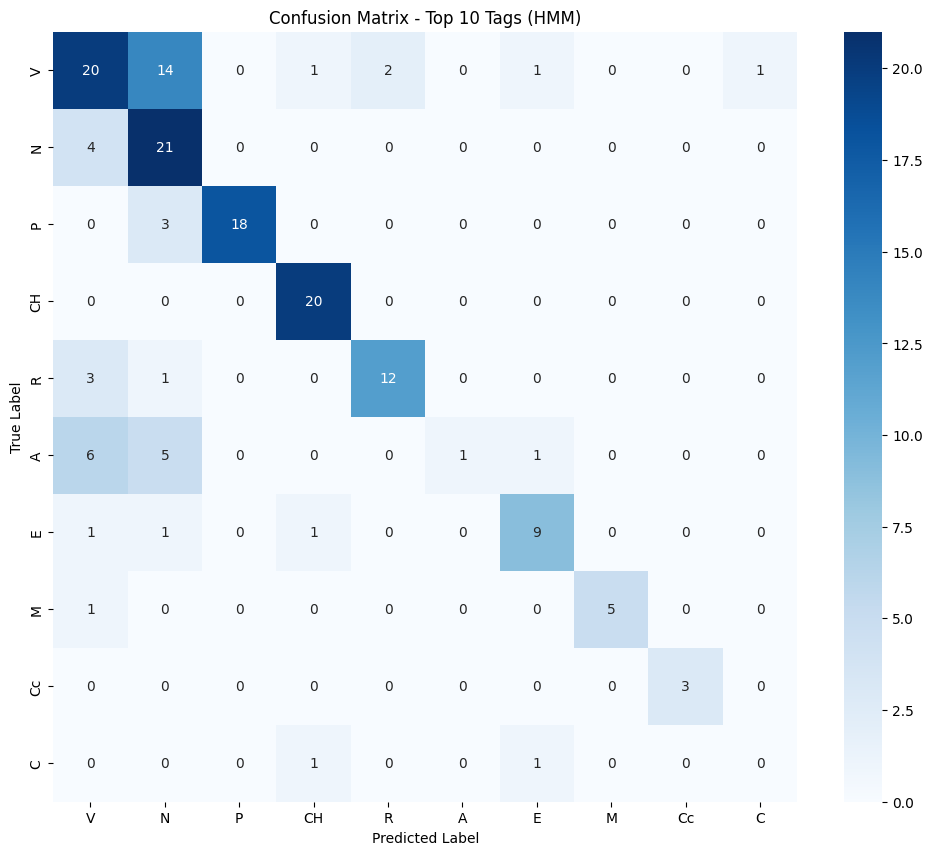


=== Method Comparison ===
     Method  Accuracy  Model Type
  Basic HMM  0.685185 Trigram HMM
Sklearn HMM  0.685185  Same model
HMM results saved to 'hmm_pos_tagging_results.csv'


In [3]:
print("Training model...")
emission_counts, trigram_counts, bigram_counts, unigram_counts, tagset, vocab = train_trigram_hmm("/kaggle/input/vn-data-pos/train.txt")

# Create probability cache
prob_cache = ProbabilityCache(emission_counts, trigram_counts, bigram_counts, tagset, vocab)

# Save the model
model_save_path = "./models/HMM_custom.pkl"
save_hmm_model(prob_cache, model_save_path)

import gc
del emission_counts, trigram_counts, bigram_counts, unigram_counts
gc.collect()

print("Training completed and model saved!")

# Basic evaluation
test_accuracy, correct, total = test_model("/kaggle/input/vn-data-pos/test.txt", prob_cache)
print(f"Basic Test Accuracy: {test_accuracy:.4f} ({correct}/{total})")

# Sklearn evaluation
print("\n" + "="*50)
print("Evaluating HMM with sklearn...")
sklearn_results = evaluate_with_sklearn("/kaggle/input/vn-data-pos/test.txt", prob_cache, verbose=True)

# Comparison table
comparison_data = {
    'Method': ['Basic HMM', 'Sklearn HMM'],
    'Accuracy': [test_accuracy, sklearn_results['overall_accuracy']],
    'Model Type': ['Trigram HMM', 'Same model']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n=== Method Comparison ===")
print(comparison_df.to_string(index=False))

# Save results
sklearn_results['summary_df'].to_csv('hmm_pos_tagging_results.csv', index=False)
print("HMM results saved to 'hmm_pos_tagging_results.csv'")

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_transition_matrix(prob_cache, top_n=15, save_path=None):
    """Visualize trigram transition probabilities as heatmap"""
    # Get most common tags (excluding sentence boundaries)
    regular_tags = [tag for tag in prob_cache.tagset if tag not in ['<s>', '</s>']]
    tag_counts = {}
    
    # Count tag frequencies from bigram counts
    for (t1, t2) in prob_cache.bigram_counts:
        if t2 in regular_tags:
            tag_counts[t2] = tag_counts.get(t2, 0) + prob_cache.bigram_counts[(t1, t2)]
    
    # Get top N most frequent tags
    top_tags = sorted(tag_counts.keys(), key=lambda x: tag_counts.get(x, 0), reverse=True)[:top_n]
    
    # Create transition probability matrix for bigrams (simplified from trigrams)
    transition_matrix = np.zeros((len(top_tags), len(top_tags)))
    
    for i, tag1 in enumerate(top_tags):
        for j, tag2 in enumerate(top_tags):
            # Use bigram probabilities for visualization
            numerator = prob_cache.bigram_counts[(tag1, tag2)] + 1
            denominator = sum(prob_cache.bigram_counts[(tag1, t)] for t in prob_cache.tagset) + len(prob_cache.tagset)
            transition_matrix[i][j] = numerator / denominator
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(transition_matrix, 
                xticklabels=top_tags, 
                yticklabels=top_tags,
                annot=True, 
                fmt='.3f', 
                cmap='Blues',
                cbar_kws={'label': 'Transition Probability'})
    
    plt.title(f'Tag Transition Matrix (Top {top_n} Tags)')
    plt.xlabel('Next Tag')
    plt.ylabel('Current Tag')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Transition matrix saved to: {save_path}")
    else:
        plt.show()
    
    plt.close()  # Close figure to free memory
    return transition_matrix, top_tags

def visualize_emission_matrix(prob_cache, top_tags=10, top_words=15, save_path=None):
    """Visualize emission probabilities as heatmap"""
    # Get most common tags (excluding sentence boundaries)
    regular_tags = [tag for tag in prob_cache.tagset if tag not in ['<s>', '</s>']]
    
    # Count tag frequencies
    tag_counts = {}
    for tag in regular_tags:
        tag_counts[tag] = prob_cache.tag_totals.get(tag, 0)
    
    # Get top N most frequent tags
    selected_tags = sorted(tag_counts.keys(), key=lambda x: tag_counts.get(x, 0), reverse=True)[:top_tags]
    
    # Get most common words for these tags
    word_counts = {}
    for tag in selected_tags:
        for word in prob_cache.emission_counts[tag]:
            if word != '<UNK>' and word not in ['.', ',', '?', "!", ';']:  # Skip unknown token for visualization
                word_counts[word] = word_counts.get(word, 0) + prob_cache.emission_counts[tag][word]
    
    # Get top words
    top_word_list = sorted(word_counts.keys(), key=lambda x: word_counts.get(x, 0), reverse=True)[:top_words]
    
    # Create emission probability matrix
    emission_matrix = np.zeros((len(selected_tags), len(top_word_list)))
    
    for i, tag in enumerate(selected_tags):
        for j, word in enumerate(top_word_list):
            numerator = prob_cache.emission_counts[tag][word] + 1
            denominator = prob_cache.tag_totals.get(tag, 0) + prob_cache.vocab_size
            emission_matrix[i][j] = numerator / denominator
    
    # Create heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(emission_matrix,
                xticklabels=top_word_list,
                yticklabels=selected_tags,
                annot=True,
                fmt='.3f',
                cmap='Blues',
                cbar_kws={'label': 'Emission Probability'})
    
    plt.title(f'Emission Matrix (Top {top_tags} Tags × Top {top_words} Words)')
    plt.xlabel('Words')
    plt.ylabel('POS Tags')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Emission matrix saved to: {save_path}")
    else:
        plt.show()
    
    plt.close()  # Close figure to free memory
    return emission_matrix, selected_tags, top_word_list

# Add a convenience function to save both matrices
def save_matrices_as_png(prob_cache, output_dir='.', top_n=10):
    """Save both transition and emission matrices as PNG files"""
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define file paths
    transition_path = os.path.join(output_dir, 'transition_matrix.png')
    emission_path = os.path.join(output_dir, 'emission_matrix.png')
    
    # Save transition matrix
    print("Generating transition matrix...")
    visualize_transition_matrix(prob_cache, top_n=top_n, save_path=transition_path)
    
    # Save emission matrix
    print("Generating emission matrix...")
    visualize_emission_matrix(prob_cache, top_tags=top_n, top_words=top_n, save_path=emission_path)
    
    print(f"\nMatrices saved in directory: {output_dir}")
    return transition_path, emission_path

def visualize_tag_distribution(prob_cache):
    """Visualize tag frequency distribution"""
    # Calculate tag frequencies
    tag_frequencies = {}
    for tag in prob_cache.tagset:
        if tag not in ['<s>', '</s>']:
            tag_frequencies[tag] = prob_cache.tag_totals.get(tag, 0)
    
    # Sort by frequency
    sorted_tags = sorted(tag_frequencies.items(), key=lambda x: x[1], reverse=True)
    
    # Create bar plot
    plt.figure(figsize=(15, 6))
    tags, frequencies = zip(*sorted_tags[:20])  # Top 20 tags
    
    plt.bar(tags, frequencies, color='skyblue', alpha=0.7)
    plt.title('POS Tag Frequency Distribution (Top 20)')
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return sorted_tags

def analyze_model_statistics(prob_cache):
    """Print detailed model statistics"""
    print("=== HMM Model Statistics ===")
    print(f"Vocabulary size: {len(prob_cache.vocab):,}")
    print(f"Tagset size: {len(prob_cache.tagset)}")
    print(f"Total trigrams: {len(prob_cache.trigram_counts):,}")
    print(f"Total bigrams: {len(prob_cache.bigram_counts):,}")
    
    # Tag statistics
    regular_tags = [tag for tag in prob_cache.tagset if tag not in ['<s>', '</s>']]
    print(f"Regular tags (excluding boundaries): {len(regular_tags)}")
    
    # Most/least frequent tags
    tag_frequencies = {tag: prob_cache.tag_totals.get(tag, 0) for tag in regular_tags}
    most_freq = max(tag_frequencies.items(), key=lambda x: x[1])
    least_freq = min(tag_frequencies.items(), key=lambda x: x[1])
    
    print(f"Most frequent tag: {most_freq[0]} ({most_freq[1]:,} occurrences)")
    print(f"Least frequent tag: {least_freq[0]} ({least_freq[1]:,} occurrences)")
    
    # Vocabulary statistics
    word_counts = {}
    for tag in prob_cache.emission_counts:
        for word in prob_cache.emission_counts[tag]:
            word_counts[word] = word_counts.get(word, 0) + prob_cache.emission_counts[tag][word]
    
    most_freq_word = max(word_counts.items(), key=lambda x: x[1])
    print(f"Most frequent word: '{most_freq_word[0]}' ({most_freq_word[1]:,} occurrences)")
    
    # Sparsity analysis
    total_possible_trigrams = len(prob_cache.tagset) ** 3
    trigram_coverage = len(prob_cache.trigram_counts) / total_possible_trigrams
    print(f"Trigram coverage: {trigram_coverage:.4f} ({len(prob_cache.trigram_counts):,}/{total_possible_trigrams:,})")

# Add this function to visualize everything at once
def visualize_hmm_model(prob_cache, top_n=5):
    """Comprehensive visualization of HMM model"""
    print("Generating HMM Model Visualizations...\n")
    
    # 1. Model statistics
    analyze_model_statistics(prob_cache)
    print("\n" + "="*50)
    
    # 2. Tag distribution
    print("1. Tag Frequency Distribution:")
    tag_stats = visualize_tag_distribution(prob_cache)
    
    # 3. Transition matrix
    print("\n2. Transition Matrix Visualization:")
    transition_matrix, top_tags = visualize_transition_matrix(prob_cache, top_n=top_n)
    
    # 4. Emission matrix
    print("\n3. Emission Matrix Visualization:")
    emission_matrix, selected_tags, top_words = visualize_emission_matrix(prob_cache, top_tags=top_n, top_words=top_n)
    
    return {
        'tag_stats': tag_stats,
        'transition_matrix': transition_matrix,
        'emission_matrix': emission_matrix,
        'top_tags': top_tags,
        'selected_tags': selected_tags,
        'top_words': top_words
    }

In [5]:
save_matrices_as_png(prob_cache, output_dir='./hmm_visualizations', top_n=4)

visualize_transition_matrix(prob_cache, top_n=12, save_path='my_transition_matrix.png')
visualize_emission_matrix(prob_cache, top_tags=8, top_words=12, save_path='my_emission_matrix.png')

Generating transition matrix...
Transition matrix saved to: ./hmm_visualizations/transition_matrix.png
Generating emission matrix...
Emission matrix saved to: ./hmm_visualizations/emission_matrix.png

Matrices saved in directory: ./hmm_visualizations
Transition matrix saved to: my_transition_matrix.png
Emission matrix saved to: my_emission_matrix.png


(array([[0.00206612, 0.04545455, 0.00206612, 0.00206612, 0.00206612,
         0.00206612, 0.02272727, 0.00206612, 0.00206612, 0.00206612,
         0.00206612, 0.02066116],
        [0.00241546, 0.00241546, 0.00241546, 0.03623188, 0.00241546,
         0.00241546, 0.00241546, 0.02657005, 0.00241546, 0.00241546,
         0.00241546, 0.00241546],
        [0.00304878, 0.00304878, 0.00304878, 0.00304878, 0.00304878,
         0.00304878, 0.00304878, 0.00304878, 0.00304878, 0.00304878,
         0.00304878, 0.00304878],
        [0.00362319, 0.00362319, 0.00362319, 0.00362319, 0.00362319,
         0.00362319, 0.00362319, 0.00362319, 0.03985507, 0.03985507,
         0.03985507, 0.00362319],
        [0.00384615, 0.00384615, 0.08461538, 0.00384615, 0.05      ,
         0.00384615, 0.00384615, 0.00384615, 0.00384615, 0.00384615,
         0.00384615, 0.00384615],
        [0.14117647, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
         0.04705882, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
  